In [1]:
import numpy as np
from neuralStellar2 import *
import pymc3 as pm
import corner
import seaborn as sns
import theano.tensor as T
import theano
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
rc("font", family="serif", size=14)
import HBMplot

Using TensorFlow backend.
C:\Users\User\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#loading in NN
m1=NNmodel('evo',['mass','age','feh','MLT'],['radius','Teff','delnu'], Teff_scaling=5000)
m1.loadModel('Ran_files/big_grid_146(h)/000_best_model.h5')
m1.getWeights()

Model: "neuralstellar"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 5)]               0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 5)                 20        
_________________________________________________________________
dense_33 (Dense)             (None, 128)               768       
_________________________________________________________________
dense_34 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_35 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_36 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_37 (Dense)             (None, 128)             

In [6]:
#loading in cluster csv
cluster_df = pd.read_csv('data_collection/NGC_2158/NGC_2158_cut.csv')
N = len(cluster_df.index)
print('There are {} stars in cluster.'.format(N))

There are 26 stars in cluster.


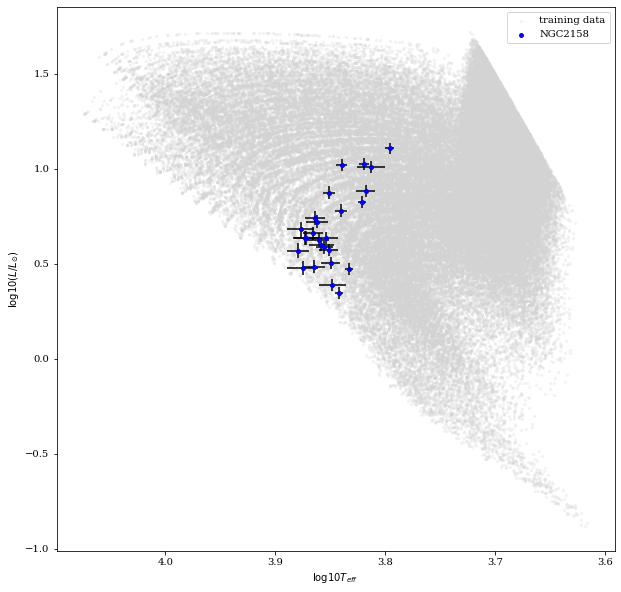

In [7]:
#showing cluster's location in HR
df = pd.read_csv('grid2_early.csv')
points = df[:100000]
HBMplot.plotClusterLocation(points, cluster_df, 'NGC2158')

## HBM!!!

In [8]:
prior_mids = [2.00, -0.29, 0.28]
prior_widths = [1, 0.4, 0.04]
max_mass = 1.7

model = pm.Model()
with model:
    Age_mu = pm.Deterministic('mean_age',pm.Beta('a',1.1,1.1)*prior_widths[0]+prior_mids[0]-0.5*prior_widths[0])
    Age_sigma = pm.Lognormal('spread_age',T.log(0.15),0.4)
    feh_mu = pm.Deterministic('mean_feh',pm.Beta('e',1.1,1.1)*prior_widths[1]+prior_mids[1]-0.5*prior_widths[1])
    feh_sigma = pm.Lognormal('spread_feh',T.log(0.05),0.5)
    Y_mu = pm.Deterministic('mean_Y',pm.Beta('f',1.1,1.1)*prior_widths[2]+prior_mids[2]-0.5*prior_widths[2])
    Y_sigma = pm.Lognormal('spread_Y',T.log(0.01),0.5)
    MLT_mu = pm.Deterministic('mean_MLT',pm.Beta('g',1.1,1.1)*0.6+1.7)
    
    M = pm.Deterministic('mass', pm.Beta('d',1.1,1.1,shape=N)*(max_mass-0.8)+0.8)
    Age = pm.Deterministic('age',pm.Normal('age_normal', 0, 1, shape=N)*Age_sigma+Age_mu)
    feh = pm.Deterministic('feh',pm.Normal('feh_normal', 0, 1, shape=N)*feh_sigma+feh_mu)
    Y = pm.Deterministic('Y',pm.Normal('Y_normal', 0, 1, shape=N)*Y_sigma+Y_mu)
    MLT = pm.Deterministic('MLT',T.ones(N)*MLT_mu)
    
    obs = pm.Deterministic('obs',m1.manualPredict(T.log10([M, Age, 10**feh, Y, MLT])))
    
    true_Teff = pm.Deterministic('true_Teff', 10**obs[1,:]*5000)
    true_L = pm.Deterministic('true_L', (10**obs[0,:])**2*(true_Teff/5776.02970722)**4)
    
    obs_L = pm.Normal('obs_L',true_L,sigma=cluster_df['cal_lum_err'], observed=cluster_df['cal_lum'])
    obs_Teff = pm.Normal('obs_Teff',true_Teff,sigma=cluster_df['Teff_err'], observed=cluster_df['Teff'])

In [9]:
#loading in track and print summary stats
trace = pm.load_trace(directory='pymc3_traces/NGC2158_1', model=model)
summary = pm.summary(trace, var_names=['mean_age','spread_age','mean_feh','spread_feh','mean_Y','spread_Y','mean_MLT'])
summary

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mean_age,1.664,0.146,1.500,1.962,0.044,0.032,11.0,11.0,17.0,34.0,1.19
spread_age,0.159,0.065,0.063,0.285,0.006,0.004,131.0,131.0,106.0,274.0,1.05
mean_feh,-0.343,0.064,-0.466,-0.227,0.008,0.006,57.0,51.0,55.0,278.0,1.06
spread_feh,0.226,0.042,0.150,0.307,0.003,0.002,205.0,205.0,184.0,234.0,1.03
mean_Y,0.283,0.011,0.264,0.300,0.001,0.000,383.0,383.0,398.0,884.0,1.01
spread_Y,0.011,0.006,0.003,0.021,0.000,0.000,372.0,372.0,392.0,571.0,1.01
mean_MLT,2.157,0.120,1.929,2.300,0.003,0.002,1357.0,1354.0,1166.0,1490.0,1.00


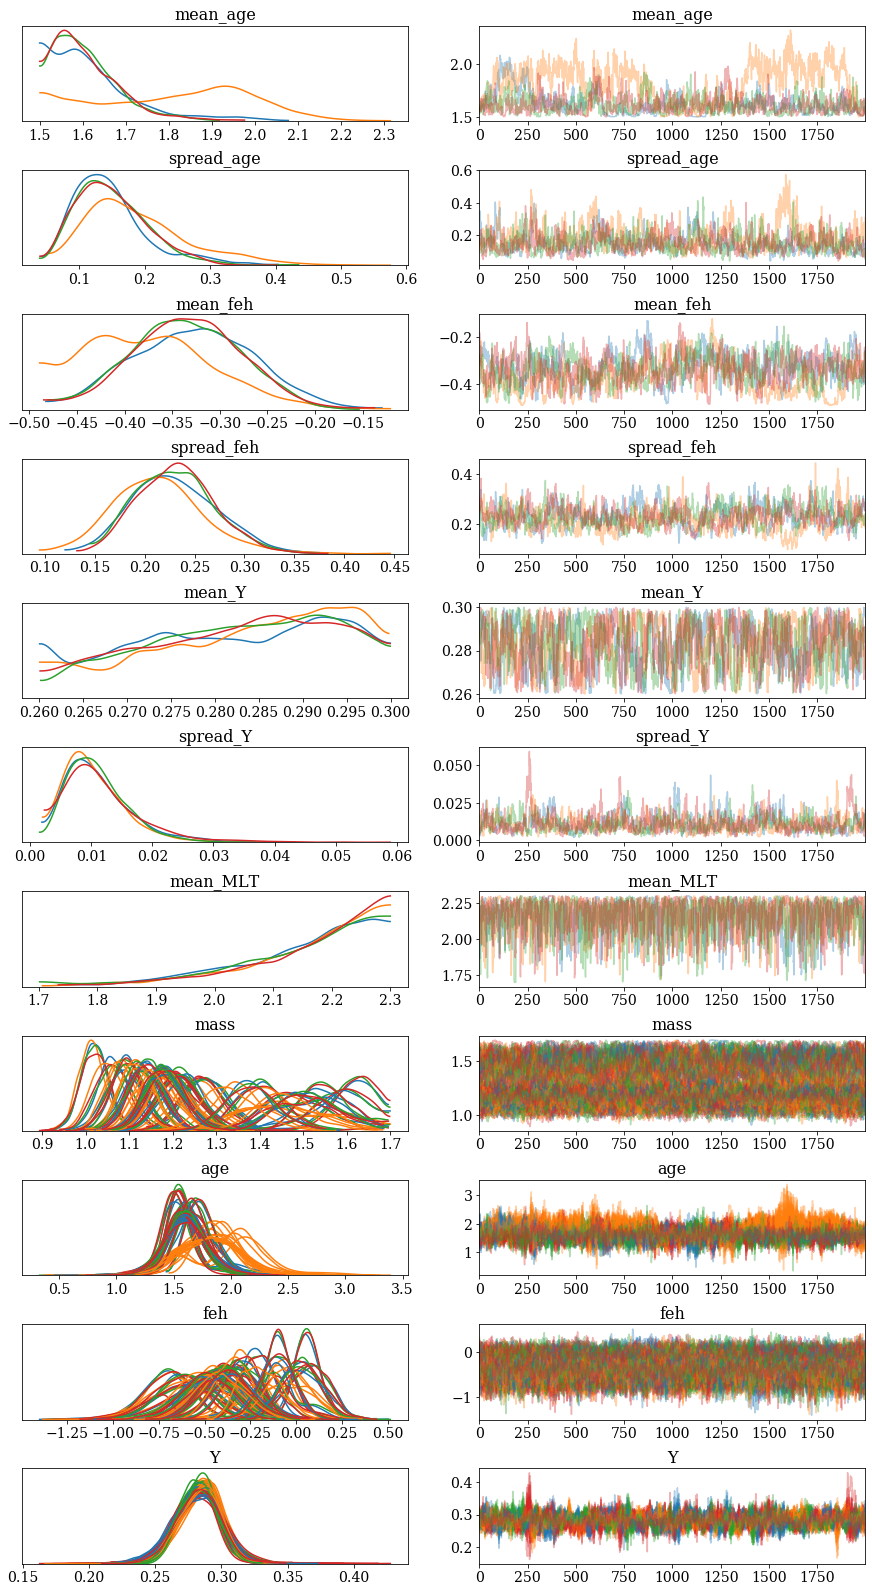

In [10]:
#trace plot
pm.plots.traceplot(trace,var_names=['mean_age','spread_age','mean_feh','spread_feh','mean_Y','spread_Y','mean_MLT','mass','age','feh','Y'],compact=True)
plt.show()

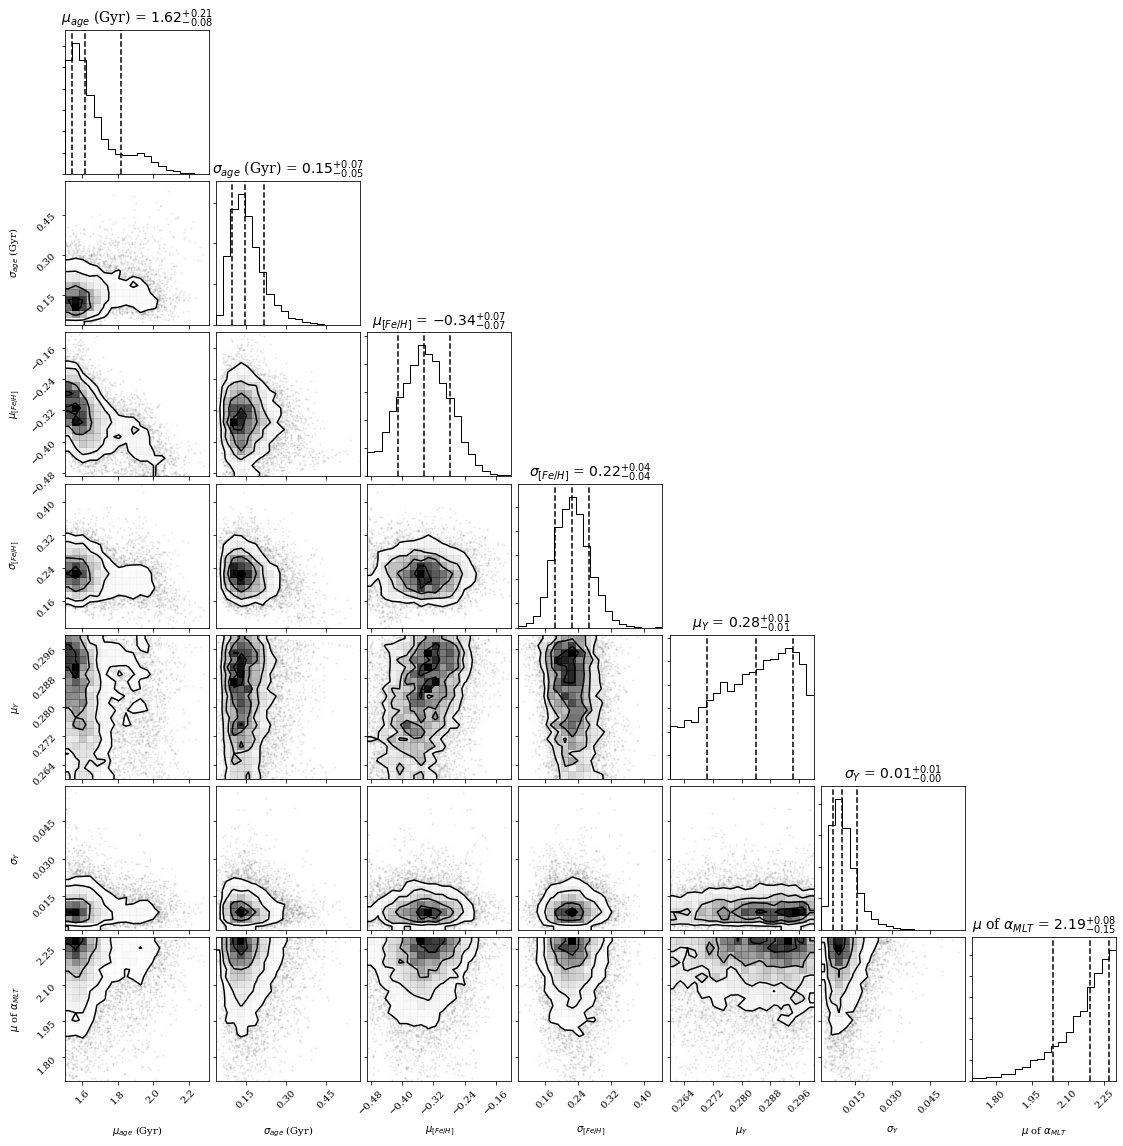

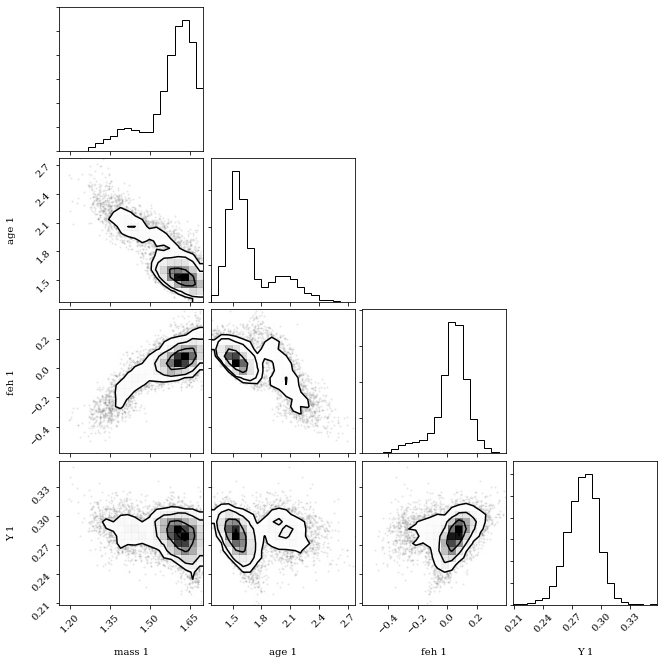

In [11]:
#corner plots
corner.corner(np.array([trace['mean_age'],trace['spread_age'],trace['mean_feh'],trace['spread_feh'],trace['mean_Y'],trace['spread_Y'],trace['mean_MLT']]).T,
              labels=[r'$\mu_{age}$ (Gyr)',r'$\sigma_{age}$ (Gyr)',r'$\mu_{[Fe/H]}$',r'$\sigma_{[Fe/H]}$',
                      r'$\mu_{Y}$',r'$\sigma_Y$',r'$\mu$ of $\alpha_{MLT}$'],
             quantiles=[0.16, 0.5, 0.84], show_titles=True, title_kwargs={"fontsize": 14})
plt.show()

corner_array=[]
labels=[]
for i,star in cluster_df.iterrows():
    corner_array.append(trace['mass'].T[i])
    corner_array.append(trace['age'].T[i])
    corner_array.append(trace['feh'].T[i])
    corner_array.append(trace['Y'].T[i])
    labels.append('mass '+str(i+1))
    labels.append('age '+str(i+1))
    labels.append('feh '+str(i+1))
    labels.append('Y '+str(i+1))
    if i==0:
        break

corner.corner(np.array(corner_array).T,labels=labels)
plt.show()

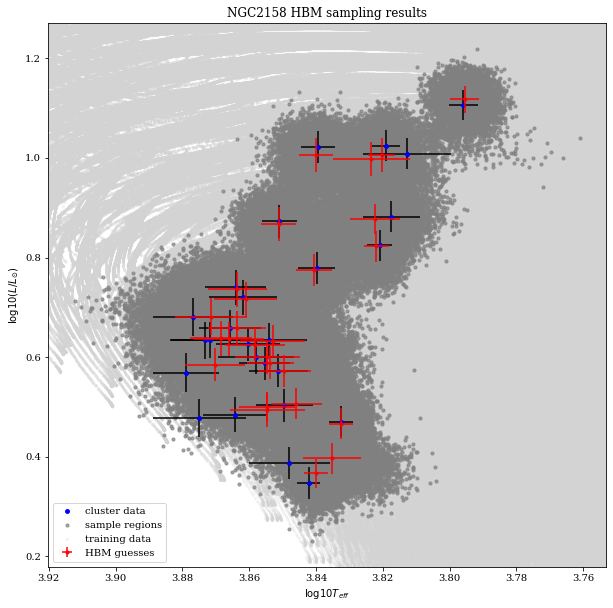

In [12]:
HBMplot.plotSample(trace, df, cluster_df, 'NGC2158 HBM sampling results', zoom_in=True)

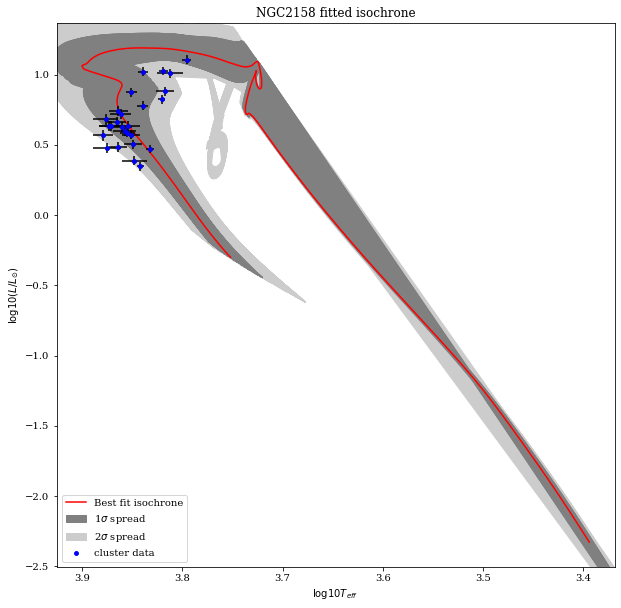

In [13]:
HBMplot.fittedIso(summary, m1.model, cluster_df, 'NGC2158 fitted isochrone')